# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# Цели и задачи проекта

**Цели:**

Провести исследование с целью построения модели машинного обучения, которая поможет определить регион, где добыча нефти принесёт наибольшую прибыль.

Результаты исследования позволят увеличить прибыль добывающей компании «ГлавРосГосНефть».

**Задачи:**

Загрузим и подготовим данные. Поясним порядок действий.

Обучим и проверим модель для каждого региона:
- 2.1. Разобьём данные на обучающую и валидационную выборки в соотношении 75:25.
- 2.2. Обучим модель и сделаем предсказания на валидационной выборке.
- 2.3. Сохраним предсказания и правильные ответы на валидационной выборке.
- 2.4. Напечатаем на экране средний запас предсказанного сырья и RMSE модели.
- 2.5. Проанализируем результаты.

Подготовимся к расчёту прибыли: 
- 3.1. Все ключевые значения для расчётов сохраним в отдельных переменных.
- 3.2. Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Сравним полученный объём сырья со средним запасом в каждом регионе.
- 3.3. Напишем выводы по этапу подготовки расчёта прибыли.

Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
- 4.1. Выберем скважины с максимальными значениями предсказаний.
- 4.2. Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям.
- 4.3. Рассчитаем прибыль для полученного объёма сырья.

Посчитаем риски и прибыль для каждого региона:
- 5.1. Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
- 5.2. Найдём среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.
- 5.3. Напишем выводы: предложим регион для разработки скважин и обоснуем выбор.

В ходе проведения исследования нам необходимо проверить гипотезу:

- Гипотеза: среди трёх регионов есть те, в которых вероятность убытков меньше 2.5%

## Загрузка и подготовка данных

In [1]:
!pip install -U seaborn -q
!pip install -U scikit-learn -q
!pip install -U plotly -q
!pip install -U phik -q

In [2]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import plotly.express as px
import phik
import seaborn as sns

In [3]:
#Сразу зададим рандом стейт
RANDOM_STATE = 42
state = np.random.RandomState(RANDOM_STATE)

Функция для анализа данных:

In [4]:
def research_data(df, cat_columns, num_columns):
    # Exclude the 'id' column from the analysis
    df = df.drop(columns='id', errors='ignore')
    cat_columns = [col for col in cat_columns if col in df.columns and col != 'id']
    num_columns = [col for col in num_columns if col in df.columns and col != 'id']

    print('\nСлучайные 5 строк данных\n')
    display(df.sample(5))
    print('\n-----------------------------\n')
    print('\nINFO\n')
    display(df.info())
    print('\n-----------------------------\n')
    print('\nОписание данных\n')
    display(df.describe(percentiles=[.05, .25, .5, .75, .95]))
    print('\n-----------------------------\n')
    print('\nДубликаты\n')
    display(df[df.duplicated()])
    print('\n-----------------------------\n')
    print('\nПропущенные значения\n')
    for c in cat_columns:
        if df[df[c].isna()].shape[0] > 0:
            display(df[df[c].isna()])
    for n in num_columns:
        if df[df[n].isna()].shape[0] > 0:
            display(df[df[n].isna()])
    print('\n-----------------------------\n')
    for i in cat_columns:
        if df[i].nunique() < 1000:  # Handle only columns with a manageable number of unique values
            _ = px.bar(df[i].value_counts(), opacity=0.75, orientation='h', text_auto=True, title=i)
            _.update_traces(marker_color='#667998')
            _.show()
    for i in num_columns:
        _ = px.histogram(df[i], opacity=0.75, marginal="box", title=i)
        _.update_traces(marker_color='#667998')
        _.show()
    print('\n-----------------------------\n')
    _ = sns.PairGrid(df)
    _.map_lower(sns.scatterplot)
    _.map_diag(sns.histplot)
    _.add_legend()
    display(_)
    print('\n-----------------------------\n')
    print('Матрица Корреляции')
    fig = px.imshow(
        df.phik_matrix(interval_cols=num_columns), 
        title='Матрица Корреляции', 
        color_continuous_scale='inferno', 
        width=600, 
        height=600, 
        text_auto=True)
    fig.layout.coloraxis.showscale = False
    fig.show()

Функция сравнивает зависимости между одним вводным признаком в первой степени и целевым признаком в первом случае и между тем же вводным признаком во второй степени и целевым признаком во втором случае:

In [5]:
def x_xsquare_compasion(data, int_feature, target_feature,):

    x = data[[int_feature]]
    y = data[[target_feature]]
    model = LinearRegression()
    model.fit(x, y)
    
    x = data[int_feature]
    y = data[target_feature]
    x_range = np.linspace(x.min(), x.max(), num=len(x))
    a = model.coef_[0]
    b = model.intercept_
    y_pred = a * x + b

    fig, ax = plt.subplots(nrows= 2, ncols= 1, figsize=(11, 11))
    
    sns.scatterplot(x=x, y=y, alpha=0.5, ax=ax[0])
    sns.lineplot(x=x_range, y=y_pred.sort_values(), color='r', ax=ax[0])
    
    x = data[[int_feature]] **2
    y = data[[target_feature]]
    model1 = LinearRegression()
    model1.fit(x, y)
    
    x1 = data[int_feature] **2
    y1 = data[target_feature]
    x_range1 = np.linspace(x1.min(), x1.max(), num=len(x1))
    a1 = model1.coef_[0]
    b1 = model1.intercept_
    y_pred1 = a1 * x1 + b1
    
    sns.scatterplot(x=x1, y=y1, alpha=0.5, ax=ax[1])
    sns.lineplot(x=x_range1, y=y_pred1.sort_values(), color='r', ax=ax[1])

    plt.show()
    r2_1 = r2_score(y, y_pred.sort_values())
    r2_2 = r2_score(y1, y_pred1.sort_values())
    print(f'''
    Коэффициент детерминации r2 при {int_feature} в первой степени = {r2_1}
    Коэффициент детерминации r2 при {int_feature} во второй степени = {r2_2}
    Разница между ними = {(r2_2 - r2_1)}
    ''')

Функция для получения и визуализации коэффициентов обученной модели на графике:

In [6]:

def show_coef(X_train, model_lr, positive=False):

    for feature_number, feature_name in enumerate(X_train.columns):
        weight = model_lr.coef_[feature_number]
        print(f"{feature_name:<20}: {weight:+.6f}") 
    
    tmp_df = pd.Series(index=X_train.columns, data=model_lr.coef_).sort_values(ascending=False)
    if positive:
        sns.barplot(x=abs(tmp_df.values), y=tmp_df.index)
    else:
        sns.barplot(x=tmp_df.values, y=tmp_df.index)
    plt.tight_layout
    plt.show()

Дополнительные настройки:

In [7]:
sns.set_style("whitegrid",
              rc={'grid.color': '#a0a0a0', 'grid.linestyle': '--'})
sns.set_palette(palette='deep', n_colors=5, desat=0.5)
sns.set_color_codes("deep")

### Загрузка данных

In [8]:
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

### geo_data_0

In [ ]:
research_data(
    geo_data_0, 
    cat_columns=[], 
    num_columns=['f0', 'f1', 'f2', 'product']
)

В датасете:
- 100 000 строк;
- Нет пропущенных значений;
- Нет дубликатов.

Признак **f0**:
- Большая часть значений находятся в отрезке между 1-м и 3-м квартилем от -0.7 до 1.07;
- На гистограмме видны четыре "гребня" на отметках -1, 0, 1 и 2(есть некая закономерность по всплеску данных);
- Имеет сильную корреляцию с f1;
- Имеет слабую корреляцию с product;
- Не имеет корреляции с f2;

Признак **f1**:
- Выбросы отсутствуют;
- Большая часть значений находятся в отрезке между 1-м и 3-м квартилем от -0.2 до 0.7;
- На гистограмме видны два "гребня" вне ящика на отметках -0.4 и 0.9;
- Имеет сильную корреляцию с f0;
- Имеет слабую корреляцию с product;
- Не имеет корреляции с f2;

Признак **f2**:
- Присутствуют выбросы ниже -6.35 и выше 11.35;
- Большая часть значений находятся в отрезке между 1-м и 3-м квартилем от 0.2877 до 4.7;
- Не имеет корреляции с f0 и f1;
- Имеет среднюю корреляцию с product;
- На диаграмме рассеяния с признакоми f0 и f1 равномерное распределение;
- На диаграмме рассеяния с признаком product просматривается линейная зависимость, но с большой дисперсией. Возможно там присутствует квадратичная зависимость. Нужно будет проверить гипотезу далее;

Целевой признак **product**:
- Большая часть значений находятся в отрезке между 1-м и 3-м квартилем от 56.5 до 128.56;
- Данные разложены на кластеры(видно на гистограмме)
- Имеет слабую корреляцию с f0 и f1;
- Имеет среднюю корреляцию с f2;
- На диаграмме рассеяния с признаком f0 и f1 видны ступеньки;
- На диаграмме рассеяния с признаком f2 просматривается линейная зависимость, но с большой дисперсией. Возможно там присутствует квадратичная зависимость. Проверим в следующей ячейке;

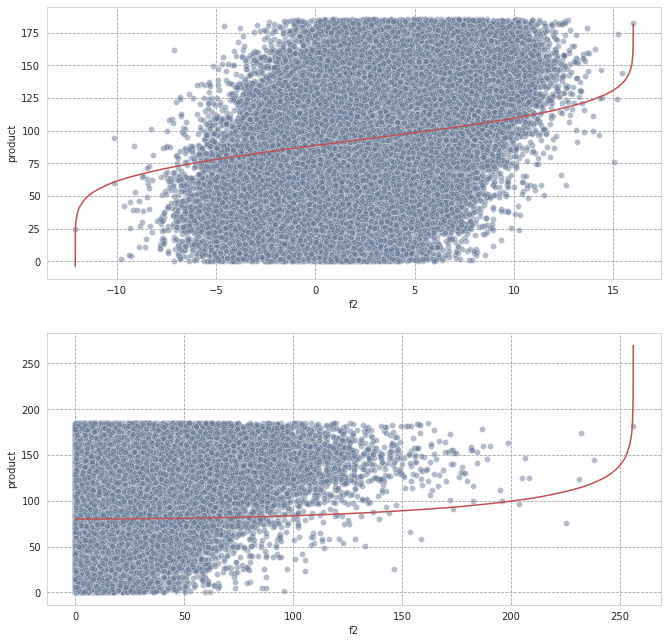


    Коэффициент детерминации r2 при f2 в первой степени = -0.23490015415607912
    Коэффициент детерминации r2 при f2 во второй степени = -0.1311214663709097
    Разница между ними = 0.10377868778516941
    


In [9]:
x_xsquare_compasion(geo_data_0, 'f2', 'product')

Коэффициент детерминации r2 увеличился: квадратичная зависимость присутствует, введем новый признак f2_square

In [65]:
geo_data_0['f2_square'] = geo_data_0['f2']**2

### geo_data_1

In [ ]:
research_data(
    geo_data_1, 
    cat_columns=[], 
    num_columns=['f0', 'f1', 'f2', 'product']
)

В датасете:
- 100 000 строк;
- Нет пропущенных значений;
- Нет дубликатов.

Признак **f0**:
- Большая часть значений находятся в отрезке между 1-м и 3-м квартилем от -6.3 до 8.6;
- На гистограмме видны два "бугра" на отметках 1-го и 3-го квартиля;
- Имеет слабую корреляцию с f1;
- Имеет высокую корреляцию с product;
- Не имеет корреляции с f2;
- На диаграмме рассеяния с признаком f1 равномерное распределение;
- На диаграмме рассеяния с признаком f2 и product 6 кластеров, похожих на категории;

Признак **f1**:
- Выбросы ниже -18.67 и выше 9.05;
- Большая часть значений находятся в отрезке между 1-м и 3-м квартилем от -8.27 до -1.33;
- На гистограмме видно нормальное распределение;
- Имеет слабую корреляцию с f0 и product;
- Не имеет корреляции с f2;
- На диаграмме рассеяния с признаком f0 отсутствует какая либо взаимосвязь;
- На диаграмме рассеяния с признаком f2 и product 6 кластеров, похожих на категории;

Признак **f2**:
- Выбросы отсутствуют;
- Большая часть значений находятся в отрезке между 1-м и 3-м квартилем от 1 до 4;
- На гистограмме 6 столбиков(как категории)
- Имеет сильную корреляцию с product;
- Не имеет корреляции с f0 и f1
- На диаграмме рассеяния с признакоми f0 и f1 6 кластеров, похожих на категории;
- На диаграмме рассеяния с признаком product есть линейная зависимость;

Целевой признак **product**:
- Выбросы отсутствуют;
- Большая часть значений находятся в отрезке между 1-м и 3-м квартилем от 26.95 до 107.81;
- Данные разложены на кластеры(видно на гистограмме)
- Имеет сильную корреляцию с f2;
- Имеет слабую корреляцию с f1;
- Имеет среднюю корреляцию с f0;
- На диаграмме рассеяния с признаком f0 и f1 6 кластеров, похожих на категории;
- На диаграмме рассеяния с признаком f2 есть линейная зависимость;

### geo_data_2

In [ ]:
research_data(
    geo_data_2, 
    cat_columns=[], 
    num_columns=['f0', 'f1', 'f2', 'product']
)

В датасете:
- 100 000 строк;
- Нет пропущенных значений;
- Нет дубликатов.

Признак **f0**:
- Выбросы ниже -4.64 и выше 4.64;
- Большая часть значений находятся в отрезке между 1-м и 3-м квартилем от -1.16 до 1.16;
- На гистограмме нормальное распределение;
- Не имеет корреляции с f1 и f2;
- Имеет слабую корреляцию с product;
- На диаграмме рассеяния с признаком f1 и f2 равномерное распределение;
- На диаграмме рассеяния с признаком product 1 кластер с малой дисперсией до значения product ~25, дальше дисперсия больше;

Признак **f1**:
- Выбросы ниже -4.68 и выше 4.67;
- Большая часть значений находятся в отрезке между 1-м и 3-м квартилем от -1.17 до -1.16;
- На гистограмме видно нормальное распределение;
- Имеет слабую корреляцию с product;
- Не имеет корреляции с f0 и f2;

Признак **f2**:
- Выбросы ниже -6.9 и выше 11.9;
- Большая часть значений находятся в отрезке между 1-м и 3-м квартилем от 0.13 до 4.86;
- На гистограмме видно нормальное распределение;
- Имеет сильную корреляцию с product;
- Не имеет корреляции с f0 и f1;
- Имеет среднюю корреляцию с product;
- На диаграмме рассеяния с признакоми f0 и f1 равномерное распределение;
- На диаграмме рассеяния с признаком product просматривается линейная зависимость, но с большой дисперсией. Возможно там присутствует квадратичная зависимость.  Нужно будет проверить гипотезу далее;

Целевой признак **product**:
- Выбросы отсутствуют;
- Большая часть значений находятся в отрезке между 1-м и 3-м квартилем от 59.45 до 130.59;
- Данные разложены на кластеры(видно на гистограмме)
- Имеет слабую корреляцию с f0 и f1;
- Имеет среднюю корреляцию с f2;
- На диаграмме рассеяния с признаком f0 и f1 1 кластер с малой дисперсией до значения product ~25, дальше дисперсия больше;
- На диаграмме рассеяния с признаком f2 просматривается линейная зависимость, но с большой дисперсией. Возможно там присутствует квадратичная зависимость. 

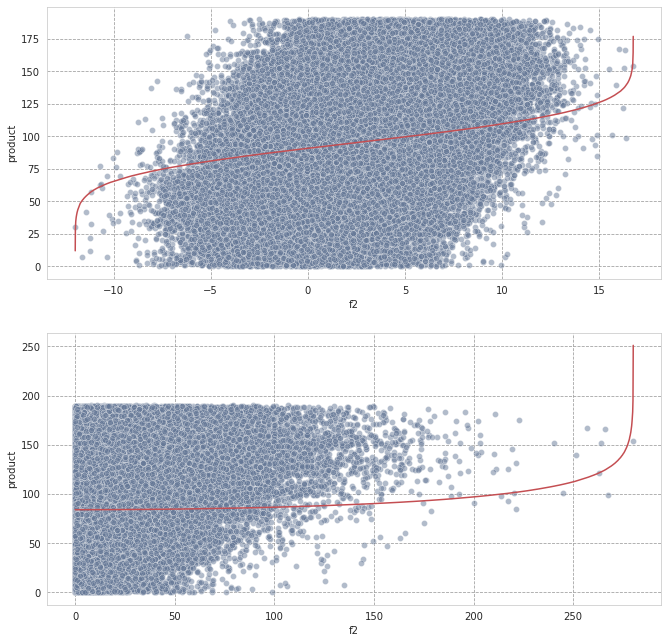


    Коэффициент детерминации r2 при f2 в первой степени = -0.19792560596492637
    Коэффициент детерминации r2 при f2 во второй степени = -0.10355688868551449
    Разница между ними = 0.09436871727941187
    


In [66]:
x_xsquare_compasion(geo_data_2, 'f2', 'product')

Коэффициент детерминации r2 увеличился! Квадратичная зависимость присутствует, введем новый признак f2_square

In [67]:
geo_data_2['f2_square'] = geo_data_2['f2']**2

### Вывод

- Произведена загрузка данных по трем регионам;

**В регионе geo_0:**
- Максимальный запас сырья в скважине 185.364347 тыс. баррелей;
- Средний запас сырья в скважине 92.5 тыс. баррелей;
**В регионе geo_1:**
- Максимальный запас сырья в скважине 137.945408 тыс. баррелей;
- Средний запас сырья в скважине 68.825 тыс. баррелей;
**В регионе geo_2:**
- Максимальный запас сырья в скважине 190.029838 тыс. баррелей;
- Средний запас сырья в скважине 95 тыс. баррелей;

На данном этапе регион geo_2 кажется самым перспективным.

Взаимосвязь данных в каждом регионе разная, но в каждом выделяется прихнак f2. Между ним и целевым признаком есть линейная зависимость. В geo_0 и geo_2 квадратичная линейная зависимость. Поэтому мы добавили дополнительный признак f2_square;


## Обучение и проверка модели

В датафреймах id сделаем индексами

In [68]:
geo_data_0 = geo_data_0.set_index('id')
geo_data_1 = geo_data_1.set_index('id')
geo_data_2 = geo_data_2.set_index('id')

Разобьем данные на обучающую и валидационную выборки в соотношении 75:25.

In [69]:
X0_train, X0_test, y0_train, y0_test = train_test_split(
    geo_data_0.drop('product', axis=1),
    geo_data_0['product'],
    test_size = 0.25, 
    random_state = RANDOM_STATE
)

In [70]:
X1_train, X1_test, y1_train, y1_test = train_test_split(
    geo_data_1.drop('product', axis=1),
    geo_data_1['product'],
    test_size = 0.25, 
    random_state = RANDOM_STATE
)

In [71]:
X2_train, X2_test, y2_train, y2_test = train_test_split(
    geo_data_2.drop('product', axis=1),
    geo_data_2['product'],
    test_size = 0.25, 
    random_state = RANDOM_STATE
)

Сделаем пайплайн в котором будем перебирать модели линейной регрессии без штрафов и со штрафами.

In [72]:
pipeline = Pipeline([
    ('preprocessor', StandardScaler()),
    ('models', LinearRegression(n_jobs=-1))
])
pipeline

Pipeline(steps=[('preprocessor', StandardScaler()),
                ('models', LinearRegression(n_jobs=-1))])

In [73]:
param_grid = [
    # словарь для модели Lasso()
    {
        'models': [Lasso(random_state=RANDOM_STATE)] 
    },
    
    # словарь для модели Ridge() 
    {
        'models': [Ridge(random_state=RANDOM_STATE)]  
    }
]

### geo_data_0

In [74]:
start = time.time()

grid_search0 = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
grid_search0.fit(X0_train, y0_train)

print ('Метрика лучшей модели на тренировочной выборке:', grid_search0.best_score_)
grid_search_time = time.time() - start
print('Время поиска', grid_search_time)
print('Лучшая модель:',grid_search0.best_estimator_.named_steps['models'])

Метрика лучшей модели на тренировочной выборке: -37.67188270310174
Время поиска 2.0636491775512695
Лучшая модель: Ridge(random_state=42)


Среднее значение в этом регионе 92.5, RMSE равный 37.7 кажется очень большим. Посмотрим на коэффициенты модели.

f0                  : +3.343632
f1                  : -7.180852
f2                  : +21.204734
f2_square           : +0.292371


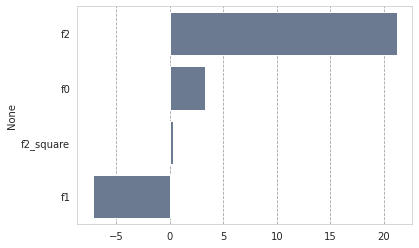

In [75]:
show_coef(X0_train, grid_search0.best_estimator_.named_steps['models'], positive=False)

Самый значимый вес у признака f2, а вот квадрат этого признака практически не влияет на предсказания модели.

In [76]:
y0_test_pred = grid_search0.predict(X0_test)
print(f'Средний запас предсказанного сырья: {y0_test_pred.mean()}')
print(f'Метрика RMSE на тестовой выборке: {root_mean_squared_error(y0_test, y0_test_pred)}')
print(f'Коэффициент детерминации R2: {r2_score(y0_test, y0_test_pred)}')

Средний запас предсказанного сырья: 92.39845756809436
Метрика RMSE на тестовой выборке: 37.75560822123564
Коэффициент детерминации R2: 0.2728669480292921


- Средний запас предсказанного сырья оказался близок к среднему истинного значения;
- Метрика RMSE на валидационной выборке так же плоха как и на обучающей;
- Коэффициент детерминации показывает, что модель дает правильные предсказания в 27% случаев.

In [ ]:
geo_0_test = X0_test.merge(y0_test, on='id')
geo_0_test['y_pred'] = y0_test_pred
geo_0_test

### geo_data_1

In [78]:
start = time.time()

grid_search1 = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
grid_search1.fit(X1_train, y1_train)

print ('Метрика лучшей модели на тренировочной выборке:', grid_search1.best_score_)
grid_search_time = time.time() - start
print('Время поиска', grid_search_time)
print('Лучшая модель:',grid_search1.best_estimator_.named_steps['models'])

Метрика лучшей модели на тренировочной выборке: -0.8904562679518498
Время поиска 1.916830062866211
Лучшая модель: Ridge(random_state=42)


Очень хорошая метрика на тренировочных данных. Посмотрим на коэффициенты модели.

f0                  : -1.298940
f1                  : -0.110914
f2                  : +45.912718


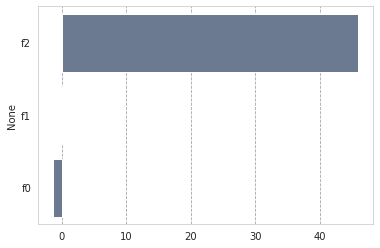

In [79]:
show_coef(X1_train, grid_search1.best_estimator_.named_steps['models'], positive=False)

Ярковыраженная линейная взаимосвязь с целевым признаком, объясняет вес признака F2/

In [80]:
y1_test_pred = grid_search1.predict(X1_test)
print(f'Средний запас предсказанного сырья: {y1_test_pred.mean()}')
print(f'Метрика RMSE на тестовой выборке: {root_mean_squared_error(y1_test, y1_test_pred)}')
print(f'Коэффициент детерминации R2: {r2_score(y1_test, y1_test_pred)}')

Средний запас предсказанного сырья: 68.712879939875
Метрика RMSE на тестовой выборке: 0.8902736110787504
Коэффициент детерминации R2: 0.9996245286737337


- Метрика на валидационной выборке такая же хорошая как и на обучающей;
- Коэффициент детерминации почти идеальный - 99.9% верных предсказаний;
- Среднее значение такое же как и истинное.

In [ ]:
geo_1_test = X1_test.merge(y1_test, on='id')
geo_1_test['y_pred'] = y1_test_pred
geo_1_test

### geo_data_2

In [82]:
start = time.time()

grid_search2 = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
grid_search2.fit(X2_train, y2_train)

print ('Метрика лучшей модели на тренировочной выборке:', grid_search2.best_score_)
grid_search_time = time.time() - start
print('Время поиска', grid_search_time)
print('Лучшая модель:',grid_search2.best_estimator_.named_steps['models'])

Метрика лучшей модели на тренировочной выборке: -40.02713669016663
Время поиска 2.0625720024108887
Лучшая модель: Ridge(random_state=42)


Самая худшая метрика среди регионов.

f0                  : -0.145437
f1                  : -0.026784
f2                  : +19.938659
f2_square           : +0.068265


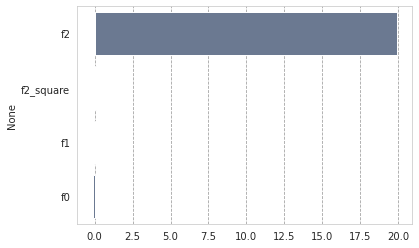

In [83]:
show_coef(X2_train, grid_search2.best_estimator_.named_steps['models'], positive=False)

Единственный весомый признак у этой модели - это f2. А f2_square оказался так же незначим. Как и остальные признаки в целом.

In [84]:
y2_test_pred = grid_search2.predict(X2_test)
print(f'Средний запас предсказанного сырья: {y2_test_pred.mean()}')
print(f'Метрика RMSE на тестовой выборке: {root_mean_squared_error(y2_test, y2_test_pred)}')
print(f'Коэффициент детерминации R2: {r2_score(y2_test, y2_test_pred)}')

Средний запас предсказанного сырья: 94.77081741133998
Метрика RMSE на тестовой выборке: 40.145827132196466
Коэффициент детерминации R2: 0.1963488685930278


- В среднее значение попали, настоящее - 95;
- Метрика RMSE велика 

In [ ]:
geo_2_test = X2_test.merge(y2_test, on='id')
geo_2_test['y_pred'] = y2_test_pred
geo_2_test

## Подготовка к расчёту прибыли

Добавим переменные где будут ключевые значения для рассчетов:

- boreholes_quantity итоговое количество скважин для разведки - 200 штук;
- budget бюджет на разработку скважин 10 млрд. рублей;
- cost стоимость 1 тыс баррелей - 450 тыс рублей;
- losses_risk риск убытков 2.5%;
- budget_and_risk бюджет с учетом рисков рассчитаем добавив 2.5% рисков из бюджета(потому что прибыль от скважин должна в итоге его превысить с учетом рисков).

In [86]:
BOREHOLES_QUANTITY = 200
BUDGET = 10000000000 #Бюджет на разработку скважин в регионе, руб
COST = 450000 #Доход с каждой единицы продукта, тыс.руб
LOSSES_RISK = 0.025 # вероятность убытков
budget_and_risk = BUDGET + BUDGET * LOSSES_RISK

Рассчитаем сколько тыс баррелей надо в среднем с каждой скважины, что бы окупить разработку.

In [87]:
average_stock = BUDGET / COST / BOREHOLES_QUANTITY
average_stock

111.11111111111111

In [88]:

print(
    f'''
    Средний запас предсказанного сырья в регионе geo_0: {y0_test_pred.mean()}
    Средний запас предсказанного сырья в регионе geo_1: {y1_test_pred.mean()}
    Средний запас предсказанного сырья в регионе geo_2: {y2_test_pred.mean()}
    '''
)


    Средний запас предсказанного сырья в регионе geo_0: 92.39845756809436
    Средний запас предсказанного сырья в регионе geo_1: 68.712879939875
    Средний запас предсказанного сырья в регионе geo_2: 94.77081741133998
    


In [89]:
print(
    f'''
    Средний запас истинного сырья в регионе geo_0: {y0_test.mean()}
    Средний запас истинного сырья в регионе geo_1: {y1_test.mean()}
    Средний запас истинного сырья в регионе geo_2: {y2_test.mean()}
    '''
)


    Средний запас истинного сырья в регионе geo_0: 92.32595637084387
    Средний запас истинного сырья в регионе geo_1: 68.72538074722745
    Средний запас истинного сырья в регионе geo_2: 95.15099907171961
    


В каждом регионе среднее значение меньше нужного как с точки зрения модели, так и истинного сырья.

Вычисленное значение оказалось выше среднего значения по регионам, но очевидно, что скважин там много и в полне вероятно, что из них можно выбрать 200 скважин подходящих нам по объему сырья.

## Расчёт прибыли и рисков 

Функция для прибыли:

In [90]:
def profit_calculation(product_volume, cost, budget):
    profit = product_volume * cost
    income = profit - budget
    return round(income)

Выберем скважины с максимальными значениями предсказаний.

In [91]:
geo_0_top = geo_0_test.sort_values(by='y_pred', ascending=False)[:200]
geo_1_top = geo_1_test.sort_values(by='y_pred', ascending=False)[:200]
geo_2_top = geo_2_test.sort_values(by='y_pred', ascending=False)[:200]

Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям.

In [92]:
geo_0_top_sum = round(geo_0_top['product'].sum(), 2)

geo_1_top_sum = round(geo_1_top['product'].sum(), 2)

geo_2_top_sum = round(geo_2_top['product'].sum(), 2)

Рассчитаем прибыль для полученного объёма сырья.

In [93]:
geo_0_profit = profit_calculation(geo_0_top_sum, COST, BUDGET)
print(f'Прибыль для полученного объема сырья в регионе geo_0: {geo_0_profit}')

geo_1_profit = profit_calculation(geo_1_top_sum, COST, BUDGET)
print(f'Прибыль для полученного объема сырья в регионе geo_1: {geo_1_profit}')

geo_2_profit = profit_calculation(geo_2_top_sum, COST, BUDGET)
print(f'Прибыль для полученного объема сырья в регионе geo_2: {geo_2_profit}')

Прибыль для полученного объема сырья в регионе geo_0: 3341582000
Прибыль для полученного объема сырья в регионе geo_1: 2415086000
Прибыль для полученного объема сырья в регионе geo_2: 2598573500


Выбрав 200 лучших скважин в каждом регионе, мы рассчитали прибыль от них и она оказалась более 10 млрд рублей. Большей по прибыли оказался регион geo_0

Применяем бутстреп для распределения прибыли для кажого региона:

In [94]:
values = []

for i in range(1000):

    subsample = geo_0_test.sample(500, replace=True, random_state=state)
    subsample = subsample.sort_values(by='y_pred', ascending=False)[:200]['product']
    
    values.append(profit_calculation(subsample.sum(), COST, BUDGET))

values = pd.Series(values) 

lower = values.quantile(0.025) 
upper = values.quantile(0.975)
mean = (lower + upper) / 2


if lower > 0:
    print(f'Минимальная средняя прибыль которая может быть получена с 200 точек выбранных из 500: {round(lower, 2):_} рублей')
else:
    print(f'Максимальные потери которые могут быть получены с 200 точек выбранных из 500: {round(lower, 2):_} рублей')

print(
    f'''
Максимальная средняя прибыль которая может быть получена с 200 точек выбранных из 500 с учетом рисков: {round(upper, 2):_} рублей
Средняя прибыль которая может быть получена с 200 точек выбранных из 500 с учетом рисков: {round(mean, 2):_} рублей
    '''
)

risk_values = []

for i in values:
    if i < 0:
        risk_values.append(i)

if LOSSES_RISK >= len(risk_values)/1000:
    print(f'Риск убытков в этом регионе {len(risk_values)/1000*100}% - это меньше 2.5%. Этот регион нам подходит!')
else:
    print(f'Риск убытков в этом регионе {len(risk_values)/1000*100}% - это больше 2.5%. Этот регион нам не подходит!')

Максимальные потери которые могут быть получены с 200 точек выбранных из 500: -115_709_290.07 рублей

Максимальная средняя прибыль которая может быть получена с 200 точек выбранных из 500 с учетом рисков: 893_637_731.32 рублей
Средняя прибыль которая может быть получена с 200 точек выбранных из 500 с учетом рисков: 388_964_220.62 рублей
    
Риск убытков в этом регионе 5.8999999999999995% - это больше 2.5%. Этот регион нам не подходит!


In [95]:
values = []

for i in range(1000):
    subsample = geo_1_test.sample(500, replace=True, random_state=state)
    subsample = subsample.sort_values(by='y_pred', ascending=False)[:200]['product']
    
    values.append(profit_calculation(subsample.sum(), COST, BUDGET))

values = pd.Series(values) 
    

lower = values.quantile(0.025) 
upper = values.quantile(0.975)
mean = (lower + upper) / 2


if lower > 0:
    print(f'Минимальная средняя прибыль которая может быть получена с 200 точек выбранных из 500: {round(lower, 2):_} рублей')
else:
    print(f'Максимальные потери которые могут быть получены с 200 точек выбранных из 500: {round(lower, 2):_} рублей')

print(
    f'''
Максимальная средняя прибыль которая может быть получена с 200 точек выбранных из 500 с учетом рисков: {round(upper, 2):_} рублей
Средняя прибыль которая может быть получена с 200 точек выбранных из 500 с учетом рисков: {round(mean, 2):_} рублей
    '''
)

risk_values = []

for i in values:
    if i < 0:
        risk_values.append(i)

if LOSSES_RISK >= len(risk_values)/1000:
    print(f'Риск убытков в этом регионе {len(risk_values)/1000*100}% - это меньше 2.5%. Этот регион нам подходит!')
else:
    print(f'Риск убытков в этом регионе {len(risk_values)/1000*100}% - это больше 2.5%. Этот регион нам не подходит!')

Минимальная средняя прибыль которая может быть получена с 200 точек выбранных из 500: 52_309_409.5 рублей

Максимальная средняя прибыль которая может быть получена с 200 точек выбранных из 500 с учетом рисков: 830_146_312.92 рублей
Средняя прибыль которая может быть получена с 200 точек выбранных из 500 с учетом рисков: 441_227_861.21 рублей
    
Риск убытков в этом регионе 0.8999999999999999% - это меньше 2.5%. Этот регион нам подходит!


In [96]:
values = []

for i in range(1000):
    subsample = geo_2_test.sample(500, replace=True, random_state=state)
    subsample = subsample.sort_values(by='y_pred', ascending=False)[:200]['product']
    
    values.append(profit_calculation(subsample.sum(), COST, BUDGET))

values = pd.Series(values) 
    

lower = values.quantile(0.025) 
upper = values.quantile(0.975)
mean = (lower + upper) / 2


if lower > 0:
    print(f'Минимальная средняя прибыль которая может быть получена с 200 точек выбранных из 500: {round(lower, 2):_} рублей')
else:
    print(f'Максимальные потери которые могут быть получены с 200 точек выбранных из 500: {round(lower, 2):_} рублей')

print(
    f'''
Максимальная средняя прибыль которая может быть получена с 200 точек выбранных из 500 с учетом рисков: {round(upper, 2):_} рублей
Средняя прибыль которая может быть получена с 200 точек выбранных из 500 с учетом рисков: {round(mean, 2):_} рублей
    '''
)

risk_values = []

for i in values:
    if i < 0:
        risk_values.append(i)

if LOSSES_RISK >= len(risk_values)/1000:
    print(f'Риск убытков в этом регионе {len(risk_values)/1000*100}% - это меньше 2.5%. Этот регион нам подходит!')
else:
    print(f'Риск убытков в этом регионе {len(risk_values)/1000*100}% - это больше 2.5%. Этот регион нам не подходит!')

Максимальные потери которые могут быть получены с 200 точек выбранных из 500: -127_779_434.68 рублей

Максимальная средняя прибыль которая может быть получена с 200 точек выбранных из 500 с учетом рисков: 907_923_483.67 рублей
Средняя прибыль которая может быть получена с 200 точек выбранных из 500 с учетом рисков: 390_072_024.5 рублей
    
Риск убытков в этом регионе 7.5% - это больше 2.5%. Этот регион нам не подходит!


## Вывод

**Вывод:**
- Регион geo_1 подходит нам по уровню риска;
- Модель показывает прибыль от ~20 до ~800 млн. рублей;
- Риски до 2.5%;
- Так же плюсом этого региона является хорошо обученная модель, которая в 99% случаев на валидационной выборке дала правильные предсказания;
- Не смтря на то что средний запас сырья в этом регионе был самый низкий и ниже рассчитанного минимума, у компании получится окупить разработку и заработать.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован